In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from analysis_utils import get_df

In [2]:
import warnings
warnings.filterwarnings('error')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ImportWarning)

identifier = '*'
df = get_df(identifier)
len_df = len(df)
print('before filtering, there are a total of', len_df, 'models')

before filtering, there are a total of 1302 models


In [3]:
df['input_channel'] = df['input_channel'].fillna(value=2)


In [4]:
len(df[df['input_channel'] == 1])

483

In [5]:
len(df[df['input_channel'] == 2])

819

# Clean Up Mixed Column dtypes: Numerical AND String

Sometimes the column valus (such as "use_pooling") has both numerical and string values (e.g. 0, 1, '0', '1'), confusing hyperparameter analysis.

In [6]:
## Command to view which columns have which dtypes
# display(df.columns.to_series().groupby(df.dtypes).groups)

In [7]:
numeric_columns = [
    'use_pooling',
    'batch_norm',
    'data_noise_gaussian',
    'save_initial',
#     'momentum', # Momentum cannot be converteed because some are None
    'k',
    'data_is_target',
    'patience',
    'weight_decay',
    'batch_size',
]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='raise')


# Filter by average CNR improvement across 3 scan batteries

In [8]:
# snr_max_tolerance = 1.0
# df_consistent_cnr_snr = df.query('target_anechoic_cyst_5mm_avg_cnr_dnn >= target_anechoic_cyst_5mm_avg_cnr_das & \
#                target_phantom_anechoic_cyst_2p5mm_avg_cnr_dnn >= target_phantom_anechoic_cyst_2p5mm_avg_cnr_das & \
#                target_in_vivo_avg_cnr_dnn >= target_in_vivo_avg_cnr_das & \
#                target_anechoic_cyst_5mm_avg_snr_dnn <= target_anechoic_cyst_5mm_avg_snr_das + ' + str(snr_max_tolerance) + ' & \
#                target_phantom_anechoic_cyst_2p5mm_avg_snr_dnn <= target_phantom_anechoic_cyst_2p5mm_avg_snr_das + ' + str(snr_max_tolerance) + ' & \
#                target_in_vivo_avg_snr_dnn <= target_in_vivo_avg_snr_das + ' + str(snr_max_tolerance))

# Filter by consistent CNR improvement across 3 scan batteries

In [9]:
consistent_cnr = df.query( \
    'target_anechoic_cyst_5mm_target_1_SNR_10dB_cnr_dnn > target_anechoic_cyst_5mm_target_1_SNR_10dB_cnr_das & \
     target_anechoic_cyst_5mm_target_2_SNR_10dB_cnr_dnn > target_anechoic_cyst_5mm_target_2_SNR_10dB_cnr_das & \
     target_anechoic_cyst_5mm_target_3_SNR_10dB_cnr_dnn > target_anechoic_cyst_5mm_target_3_SNR_10dB_cnr_das & \
     target_anechoic_cyst_5mm_target_4_SNR_10dB_cnr_dnn > target_anechoic_cyst_5mm_target_4_SNR_10dB_cnr_das & \
     target_anechoic_cyst_5mm_target_5_SNR_10dB_cnr_dnn > target_anechoic_cyst_5mm_target_5_SNR_10dB_cnr_das & \
     target_phantom_anechoic_cyst_2p5mm_target_1_cnr_dnn > target_phantom_anechoic_cyst_2p5mm_target_1_cnr_das & \
     target_phantom_anechoic_cyst_2p5mm_target_2_cnr_dnn > target_phantom_anechoic_cyst_2p5mm_target_2_cnr_das & \
     target_phantom_anechoic_cyst_2p5mm_target_3_cnr_dnn > target_phantom_anechoic_cyst_2p5mm_target_3_cnr_das & \
     target_phantom_anechoic_cyst_2p5mm_target_4_cnr_dnn > target_phantom_anechoic_cyst_2p5mm_target_4_cnr_das & \
     target_phantom_anechoic_cyst_2p5mm_target_5_cnr_dnn > target_phantom_anechoic_cyst_2p5mm_target_5_cnr_das & \
     target_in_vivo_target_17_cnr_dnn > target_in_vivo_target_17_cnr_das & \
     target_in_vivo_target_19_cnr_dnn > target_in_vivo_target_19_cnr_das')


In [10]:
len(consistent_cnr)

156

# Label rows with consistent or not

In [11]:
df.loc[df.index.isin(consistent_cnr.index), 'consistent'] = True
df.loc[~df.index.isin(consistent_cnr.index), 'consistent'] = False

In [12]:
consistent_mask = df['consistent']

consistent = df[consistent_mask]
inconsistent = df[~consistent_mask]

num_consistent = len(consistent)
num_inconsistent = len(inconsistent)

print(num_consistent, num_inconsistent)


156 1146


# Plotting Helpers

### Let's only consider CNR among CONSISTENT models

In [52]:
# Discrete boxplot
# TODO: Check x label correctness!
def boxplot_cnr_vs_discrete_attributes(x_column, y_column, df_to_use, ax=None):
    discrete_column_values = sorted(list(df_to_use.loc[:, x_column].unique()))
    print('discrete_column_values =', discrete_column_values)
    cnr_dists_for_discrete_column_values = [df_to_use[df_to_use[x_column] == discrete_column_value].loc[:, y_column].values for discrete_column_value in discrete_column_values]
    
    ax = ax or plt.gca()
#     fig, ax = plt.subplots(figsize=(12,8))
#     ax.set_title('CNR distributions for distinct values of: {}'.format(x_column))
    for cnr_dists_for_discrete_column_value in cnr_dists_for_discrete_column_values:
        print('len(cnr_dists_for_discrete_column_value) =', len(cnr_dists_for_discrete_column_value))
#     print('cnr_dists_for_discrete_column_values =', cnr_dists_for_discrete_column_values)
    ax.boxplot(cnr_dists_for_discrete_column_values, labels=discrete_column_values, showmeans=True, meanline=True)
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
#     ax.set_xticks(range(len(discrete_column_values)), discrete_column_values)
#     ax.set_xticklabels(discrete_column_values)
#     set_xticklabels

#     plt.show()


In [14]:
def consistent_vs_inconsistent_discrete(column, show_numbers=True):
    population_weights = df[column].value_counts(sort=False) / len(df)
    
    consistent_dist = consistent[column].value_counts(sort=False) / population_weights / num_consistent / len(population_weights)
    consistent_dist = consistent_dist.fillna(value=0)
    
    inconsistent_dist = inconsistent[column].value_counts(sort=False) / population_weights / num_inconsistent / len(population_weights)
    inconsistent_dist = inconsistent_dist.fillna(value=0)
    
#     fig, axis = plt.subplots(1, 1)
    
#     consistent_dist_max = consistent_dist.max()
#     inconsistent_dist_max = inconsistent_dist.max()
    
#     axis.set_xlim([])
    
    plt.bar(consistent_dist.index, consistent_dist.values, alpha=0.5, color='blue', label='consistent');
    
#     if show_numbers is True:
#         axis = plt.gca()
#         xmin, xmax = axis.get_xlim()
#         ymin, ymax = axis.get_ylim()
        
#         axis.set_xlim([xmin-0.25, xmax+0.25])
#         axis.set_ylim([ymin, ymax+0.25])
        
    if show_numbers is True:
        for i, v in enumerate(consistent_dist.values):
            plt.text(i, v, '{0:.2g}'.format(v), va='center', color='blue', fontweight='bold', fontsize=9) # .set_clip_on(True)
    
    plt.bar(inconsistent_dist.index, inconsistent_dist.values, alpha=0.5, color='red', label='inconsistent');
    
    if show_numbers is True:
        for i, v in enumerate(inconsistent_dist.values):
            plt.text(i, v, '{0:.2g}'.format(v), va='center', color='red', fontweight='bold', fontsize=9) # .set_clip_on(True)
        
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Normalized Percentage')
    plt.xlabel(column)
    
    


In [15]:
def consistent_vs_inconsistent_continuous(column, bins=20, width=0.03):
    hist, bin_edges = np.histogram(df[column], bins=bins)
    weights = hist / len_df
    
#     print('weights =', weights)

    hist_consistent, bin_edges_consistent = np.histogram(consistent[column], bins=bin_edges)
    hist_inconsistent, bin_edges_inconsistent = np.histogram(inconsistent[column], bins=bin_edges)

    normalized_hist_consistent = hist_consistent / num_consistent / weights / len(weights)
    normalized_hist_inconsistent = hist_inconsistent / num_inconsistent / weights / len(weights)
    
    normalized_hist_consistent = np.nan_to_num(normalized_hist_consistent) 
    normalized_hist_inconsistent = np.nan_to_num(normalized_hist_inconsistent)   
#     normalized_hist_inconsistent.sum() # TODO: why is this not summing to 1?
#     normalized_hist_consistent.sum() # TODO: why is this not summing to 1?

    plt.bar(bin_edges_consistent[:-1], normalized_hist_consistent, width=width, color='blue', alpha=0.5, label='consistent');
    plt.bar(bin_edges_inconsistent[:-1], normalized_hist_inconsistent, width=width, color='red', alpha=0.5, label='inconsistent');
    
    plt.xlabel(column)
    plt.ylabel('Percentage')
    plt.legend()
    
    
    


# Distribution of input_channel among consistent vs inconsistent models

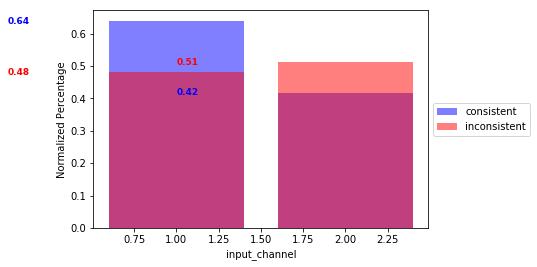

In [16]:
consistent_vs_inconsistent_discrete('input_channel')
# TODO: use two-bar bar graphs


discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 74
len(cnr_dists_for_discrete_column_value) = 82


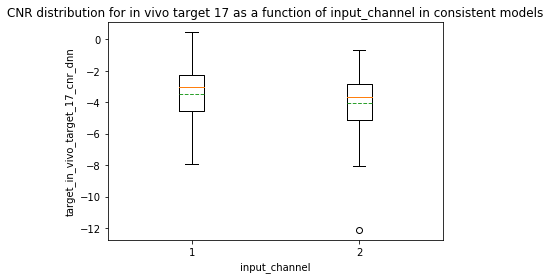

In [53]:
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_in_vivo_target_17_cnr_dnn', consistent)
ax = plt.gca()
ax.set_title('CNR distribution for in vivo target 17 as a function of input_channel in consistent models')
plt.show()


In [18]:
len(consistent[consistent['input_channel'] == 1])

74

In [19]:
len(consistent[consistent['input_channel'] == 2])

82

### In vivo CNR Distribution for 1- vs 2-layer CNNs in consistent vs all models

discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 74
len(cnr_dists_for_discrete_column_value) = 82
discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 74
len(cnr_dists_for_discrete_column_value) = 82
discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 483
len(cnr_dists_for_discrete_column_value) = 819
discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 483
len(cnr_dists_for_discrete_column_value) = 819


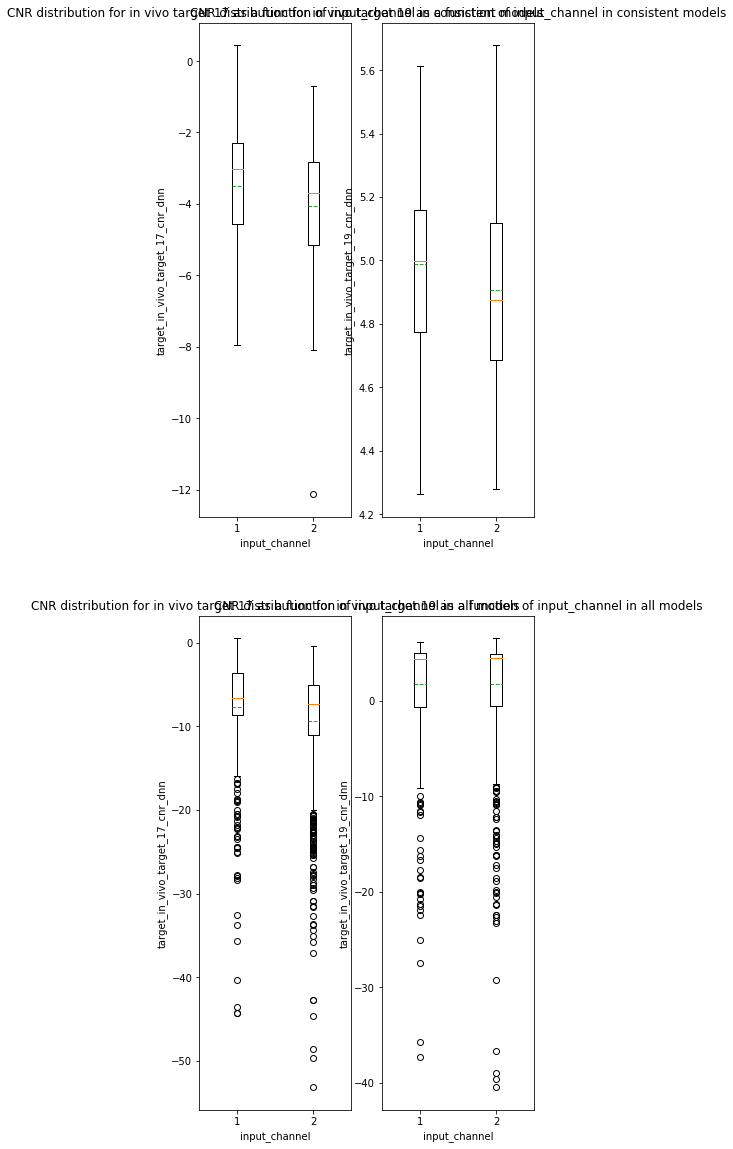

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(6, 20))

axes[0,0].set_title('CNR distribution for in vivo target 17 as a function of input_channel in consistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_in_vivo_target_17_cnr_dnn', consistent, ax=axes[0,0])


axes[0,1].set_title('CNR distribution for in vivo target 19 as a function of input_channel in consistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_in_vivo_target_19_cnr_dnn', consistent, ax=axes[0,1])

axes[1,0].set_title('CNR distribution for in vivo target 17 as a function of input_channel in all models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_in_vivo_target_17_cnr_dnn', df, ax=axes[1,0])


axes[1,1].set_title('CNR distribution for in vivo target 19 as a function of input_channel in all models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_in_vivo_target_19_cnr_dnn', df, ax=axes[1,1])

# plt.tight_layout()
plt.show()



### Phantom CNR Distribution for 1- vs 2-layer CNNs in consistent-only models

discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 74
len(cnr_dists_for_discrete_column_value) = 82
discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 74
len(cnr_dists_for_discrete_column_value) = 82
discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 74
len(cnr_dists_for_discrete_column_value) = 82
discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 74
len(cnr_dists_for_discrete_column_value) = 82
discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 74
len(cnr_dists_for_discrete_column_value) = 82


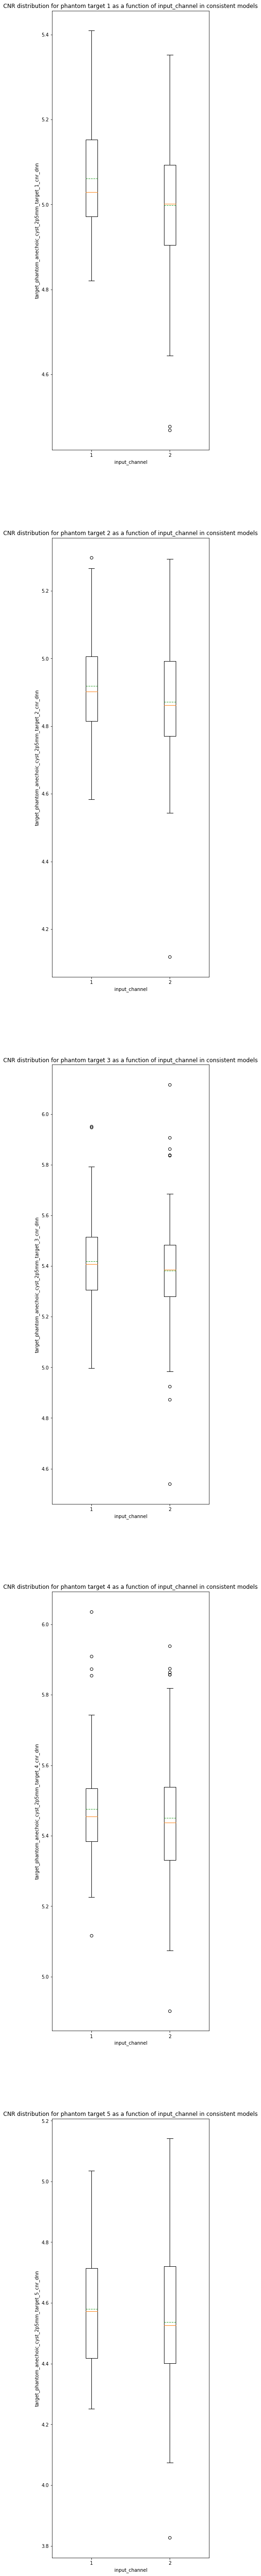

In [67]:
# fig, axes = plt.subplots(2, 2, figsize=(20, 20))
fig, axes = plt.subplots(5, 1, figsize=(6, 100))

axes[0].set_title('CNR distribution for phantom target 1 as a function of input_channel in consistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_phantom_anechoic_cyst_2p5mm_target_1_cnr_dnn', consistent, ax=axes[0])

axes[1].set_title('CNR distribution for phantom target 2 as a function of input_channel in consistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_phantom_anechoic_cyst_2p5mm_target_2_cnr_dnn', consistent, ax=axes[1])

axes[2].set_title('CNR distribution for phantom target 3 as a function of input_channel in consistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_phantom_anechoic_cyst_2p5mm_target_3_cnr_dnn', consistent, ax=axes[2])

axes[3].set_title('CNR distribution for phantom target 4 as a function of input_channel in consistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_phantom_anechoic_cyst_2p5mm_target_4_cnr_dnn', consistent, ax=axes[3])

axes[4].set_title('CNR distribution for phantom target 5 as a function of input_channel in consistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_phantom_anechoic_cyst_2p5mm_target_5_cnr_dnn', consistent, ax=axes[4])

# plt.tight_layout()
plt.show()



### Phantom CNR Distribution for 1- vs 2-layer CNNs in consistent+inconsistent models

discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 483
len(cnr_dists_for_discrete_column_value) = 819
discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 483
len(cnr_dists_for_discrete_column_value) = 819
discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 483
len(cnr_dists_for_discrete_column_value) = 819
discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 483
len(cnr_dists_for_discrete_column_value) = 819
discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 483
len(cnr_dists_for_discrete_column_value) = 819


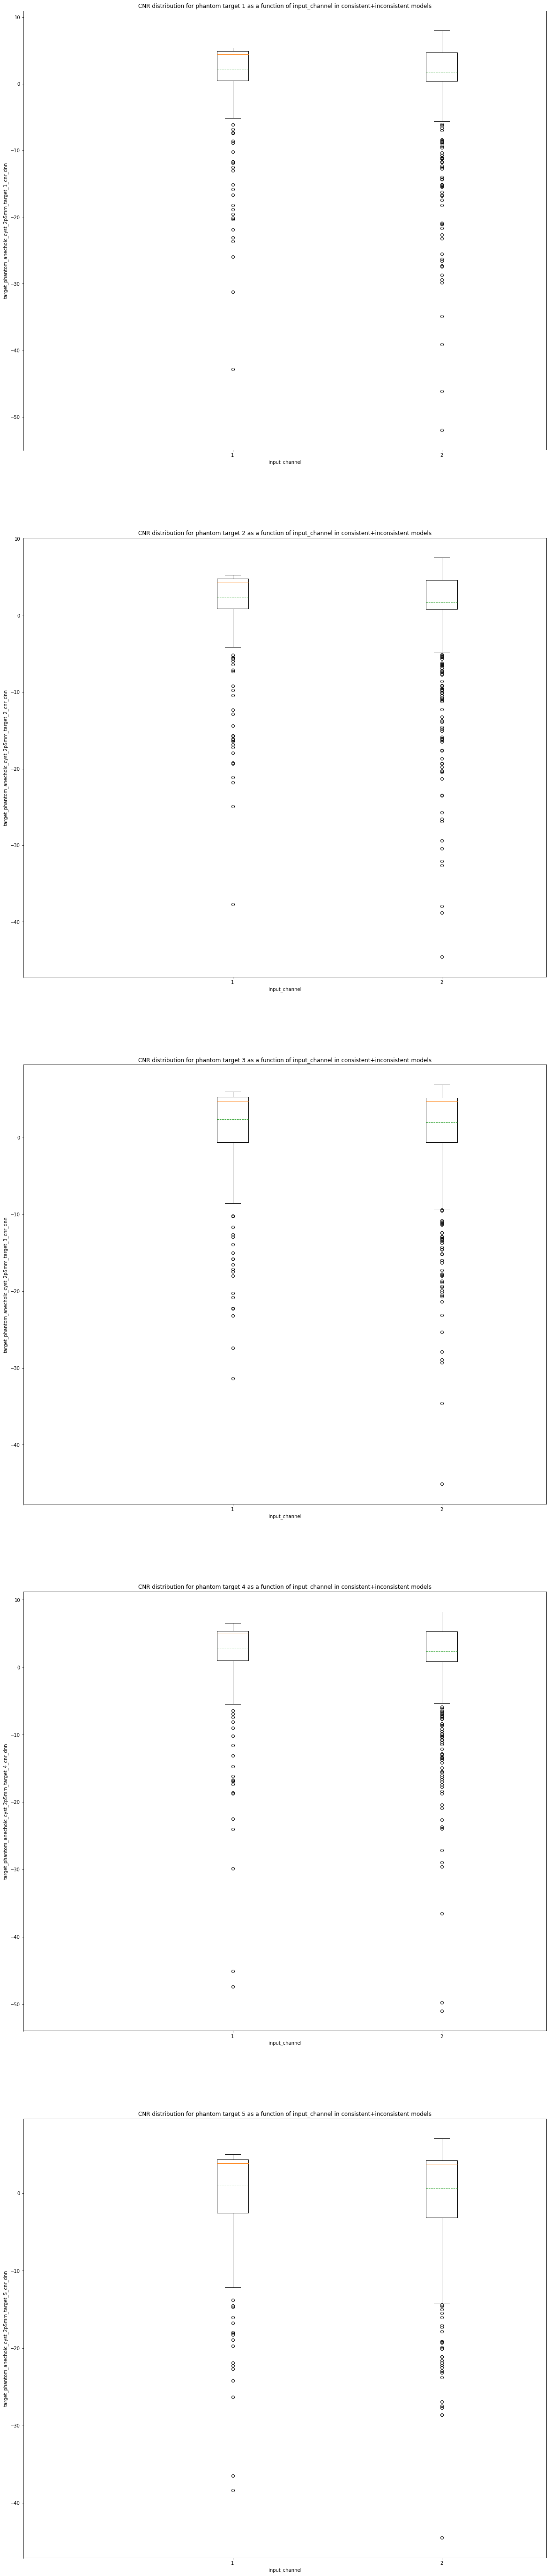

In [22]:
# fig, axes = plt.subplots(2, 2, figsize=(20, 20))
fig, axes = plt.subplots(5, 1, figsize=(20, 100))

axes[0].set_title('CNR distribution for phantom target 1 as a function of input_channel in consistent+inconsistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_phantom_anechoic_cyst_2p5mm_target_1_cnr_dnn', df, ax=axes[0])

axes[1].set_title('CNR distribution for phantom target 2 as a function of input_channel in consistent+inconsistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_phantom_anechoic_cyst_2p5mm_target_2_cnr_dnn', df, ax=axes[1])

axes[2].set_title('CNR distribution for phantom target 3 as a function of input_channel in consistent+inconsistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_phantom_anechoic_cyst_2p5mm_target_3_cnr_dnn', df, ax=axes[2])

axes[3].set_title('CNR distribution for phantom target 4 as a function of input_channel in consistent+inconsistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_phantom_anechoic_cyst_2p5mm_target_4_cnr_dnn', df, ax=axes[3])

axes[4].set_title('CNR distribution for phantom target 5 as a function of input_channel in consistent+inconsistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_phantom_anechoic_cyst_2p5mm_target_5_cnr_dnn', df, ax=axes[4])

# plt.tight_layout()
plt.show()



# What percentage of consistent models use pooling?

Only 39.6% of all models use pooling. Normalize by the population distribution.

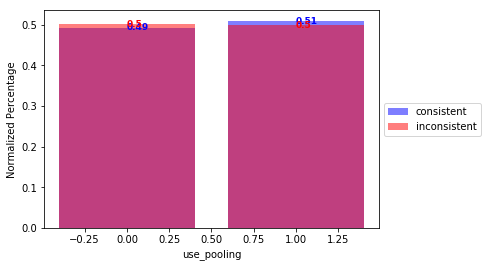

In [23]:
consistent_vs_inconsistent_discrete('use_pooling')


### Consistent - Phantom, input_channel

discrete_column_values = [0, 1]
len(cnr_dists_for_discrete_column_value) = 87
len(cnr_dists_for_discrete_column_value) = 69
discrete_column_values = [0, 1]
len(cnr_dists_for_discrete_column_value) = 87
len(cnr_dists_for_discrete_column_value) = 69
discrete_column_values = [0, 1]
len(cnr_dists_for_discrete_column_value) = 87
len(cnr_dists_for_discrete_column_value) = 69
discrete_column_values = [0, 1]
len(cnr_dists_for_discrete_column_value) = 87
len(cnr_dists_for_discrete_column_value) = 69
discrete_column_values = [0, 1]
len(cnr_dists_for_discrete_column_value) = 87
len(cnr_dists_for_discrete_column_value) = 69


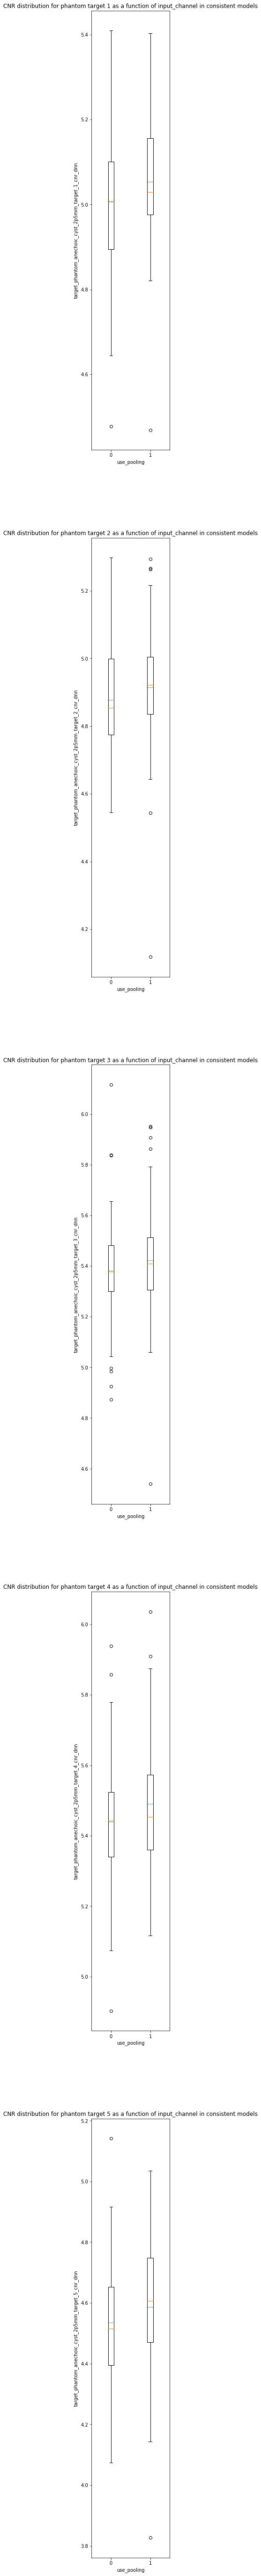

In [62]:
# fig, axes = plt.subplots(2, 2, figsize=(20, 20))
fig, axes = plt.subplots(5, 1, figsize=(3, 100))

axes[0].set_title('CNR distribution for phantom target 1 as a function of input_channel in consistent models')
boxplot_cnr_vs_discrete_attributes('use_pooling', 'target_phantom_anechoic_cyst_2p5mm_target_1_cnr_dnn', consistent, ax=axes[0])

axes[1].set_title('CNR distribution for phantom target 2 as a function of input_channel in consistent models')
boxplot_cnr_vs_discrete_attributes('use_pooling', 'target_phantom_anechoic_cyst_2p5mm_target_2_cnr_dnn', consistent, ax=axes[1])

axes[2].set_title('CNR distribution for phantom target 3 as a function of input_channel in consistent models')
boxplot_cnr_vs_discrete_attributes('use_pooling', 'target_phantom_anechoic_cyst_2p5mm_target_3_cnr_dnn', consistent, ax=axes[2])

axes[3].set_title('CNR distribution for phantom target 4 as a function of input_channel in consistent models')
boxplot_cnr_vs_discrete_attributes('use_pooling', 'target_phantom_anechoic_cyst_2p5mm_target_4_cnr_dnn', consistent, ax=axes[3])

axes[4].set_title('CNR distribution for phantom target 5 as a function of input_channel in consistent models')
boxplot_cnr_vs_discrete_attributes('use_pooling', 'target_phantom_anechoic_cyst_2p5mm_target_5_cnr_dnn', consistent, ax=axes[4])

# plt.tight_layout()
plt.show()



### Inconsistent

discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 483
len(cnr_dists_for_discrete_column_value) = 819
discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 483
len(cnr_dists_for_discrete_column_value) = 819
discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 483
len(cnr_dists_for_discrete_column_value) = 819
discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 483
len(cnr_dists_for_discrete_column_value) = 819
discrete_column_values = [1, 2]
len(cnr_dists_for_discrete_column_value) = 483
len(cnr_dists_for_discrete_column_value) = 819


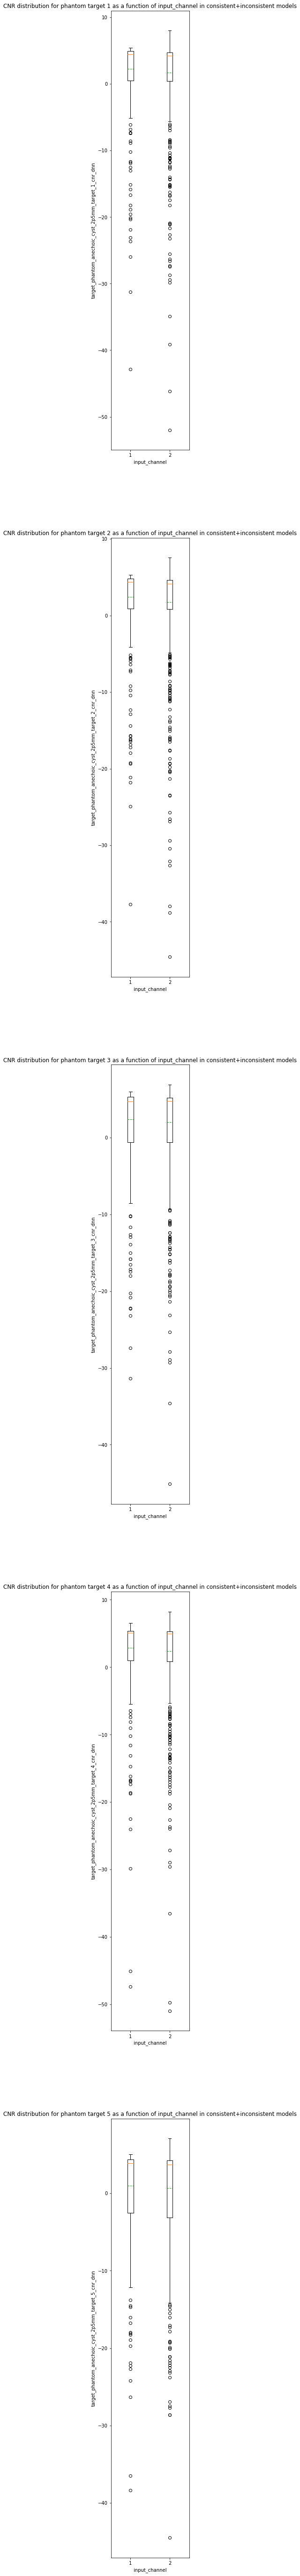

In [61]:
# fig, axes = plt.subplots(2, 2, figsize=(20, 20))
fig, axes = plt.subplots(5, 1, figsize=(3, 100))

axes[0].set_title('CNR distribution for phantom target 1 as a function of input_channel in consistent+inconsistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_phantom_anechoic_cyst_2p5mm_target_1_cnr_dnn', df, ax=axes[0])

axes[1].set_title('CNR distribution for phantom target 2 as a function of input_channel in consistent+inconsistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_phantom_anechoic_cyst_2p5mm_target_2_cnr_dnn', df, ax=axes[1])

axes[2].set_title('CNR distribution for phantom target 3 as a function of input_channel in consistent+inconsistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_phantom_anechoic_cyst_2p5mm_target_3_cnr_dnn', df, ax=axes[2])

axes[3].set_title('CNR distribution for phantom target 4 as a function of input_channel in consistent+inconsistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_phantom_anechoic_cyst_2p5mm_target_4_cnr_dnn', df, ax=axes[3])

axes[4].set_title('CNR distribution for phantom target 5 as a function of input_channel in consistent+inconsistent models')
boxplot_cnr_vs_discrete_attributes('input_channel', 'target_phantom_anechoic_cyst_2p5mm_target_5_cnr_dnn', df, ax=axes[4])

# plt.tight_layout()
plt.show()



# What percentage of consistent vs inconsistent models use batch norm?

59.71% of population use batch_norm. Normalize that by punishing where batch_norm == 1

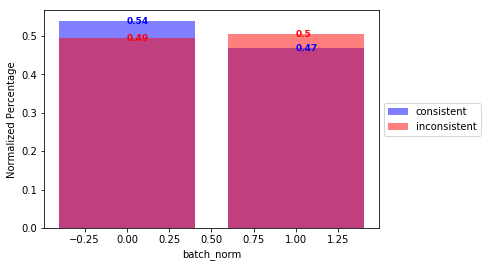

In [26]:
consistent_vs_inconsistent_discrete('batch_norm')

discrete_column_values = [0, 1]
len(cnr_dists_for_discrete_column_value) = 76
len(cnr_dists_for_discrete_column_value) = 80
discrete_column_values = [0, 1]
len(cnr_dists_for_discrete_column_value) = 76
len(cnr_dists_for_discrete_column_value) = 80


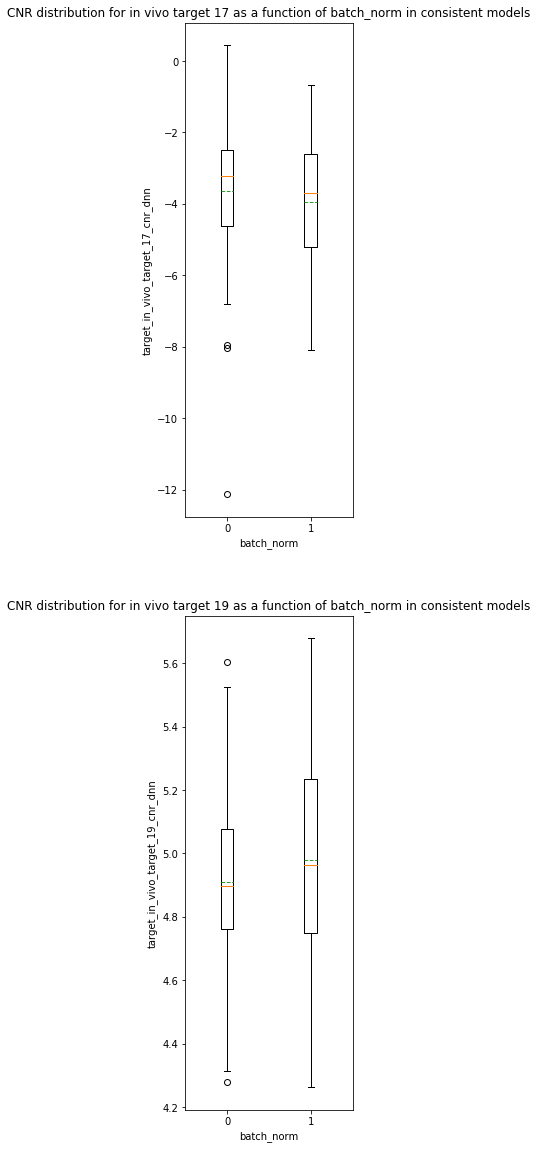

In [68]:
fig, axes = plt.subplots(2, figsize=(3, 20))

axes[0].set_title('CNR distribution for in vivo target 17 as a function of batch_norm in consistent models')
boxplot_cnr_vs_discrete_attributes('batch_norm', 'target_in_vivo_target_17_cnr_dnn', consistent, ax=axes[0])


axes[1].set_title('CNR distribution for in vivo target 19 as a function of batch_norm in consistent models')
boxplot_cnr_vs_discrete_attributes('batch_norm', 'target_in_vivo_target_19_cnr_dnn', consistent, ax=axes[1])

plt.show()

# What percentage of consistent vs inconsistent models use gaussian noise?

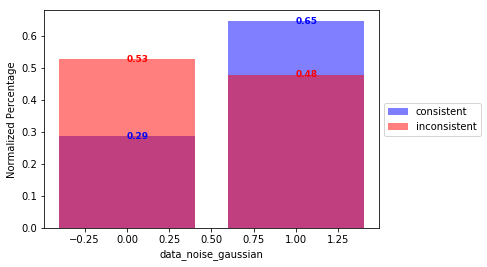

In [27]:
consistent_vs_inconsistent_discrete('data_noise_gaussian')

discrete_column_values = [0, 1]
len(cnr_dists_for_discrete_column_value) = 37
len(cnr_dists_for_discrete_column_value) = 119
discrete_column_values = [0, 1]
len(cnr_dists_for_discrete_column_value) = 37
len(cnr_dists_for_discrete_column_value) = 119


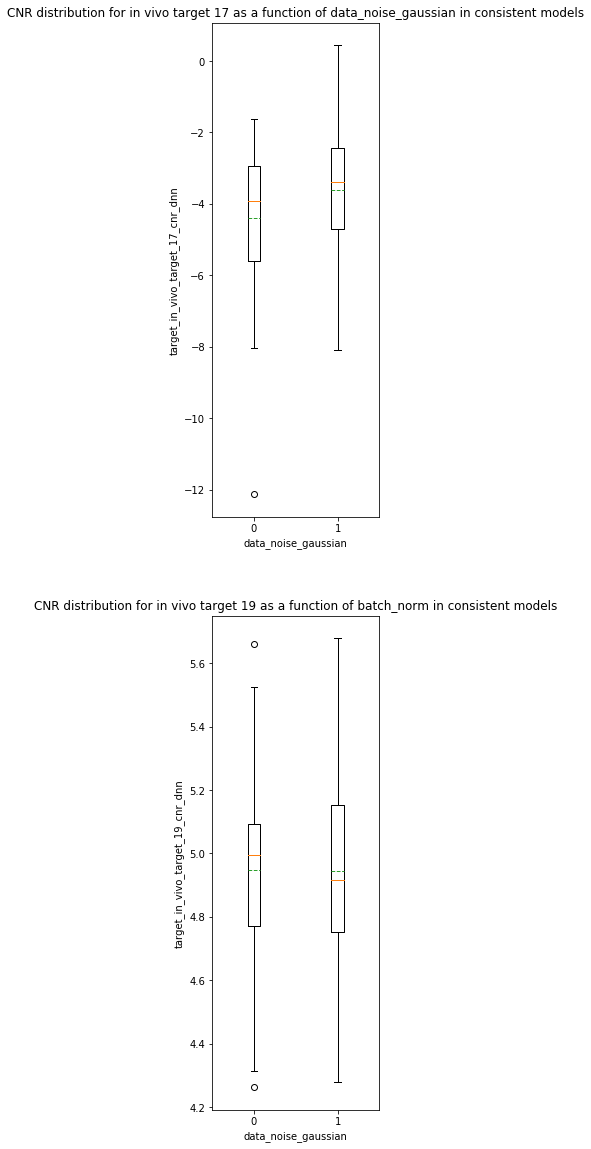

In [70]:
fig, axes = plt.subplots(2, figsize=(3, 20))

column = 'data_noise_gaussian'

axes[0].set_title('CNR distribution for in vivo target 17 as a function of {} in consistent models'.format(column))
boxplot_cnr_vs_discrete_attributes(column, 'target_in_vivo_target_17_cnr_dnn', consistent, ax=axes[0])


axes[1].set_title('CNR distribution for in vivo target 19 as a function of batch_norm in consistent models')
boxplot_cnr_vs_discrete_attributes(column, 'target_in_vivo_target_19_cnr_dnn', consistent, ax=axes[1])

plt.show()

# Distribution of conv1_kernel_width among consistent vs inconsistent models

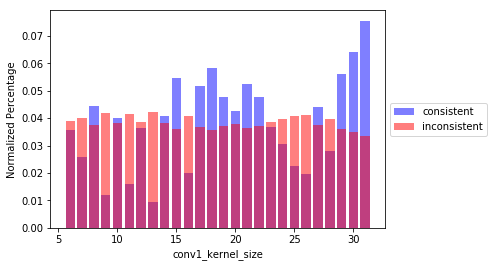

In [28]:
# Note: we didn't allow larger kernel sizes until later
# consistent_vs_inconsistent_histogram('conv1_kernel_width', bins=100)
consistent_vs_inconsistent_discrete('conv1_kernel_width', show_numbers=False)

discrete_column_values = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
len(cnr_dists_for_discrete_column_value) = 7
len(cnr_dists_for_discrete_column_value) = 8
len(cnr_dists_for_discrete_column_value) = 10
len(cnr_dists_for_discrete_column_value) = 3
len(cnr_dists_for_discrete_column_value) = 6
len(cnr_dists_for_discrete_column_value) = 2
len(cnr_dists_for_discrete_column_value) = 5
len(cnr_dists_for_discrete_column_value) = 1
len(cnr_dists_for_discrete_column_value) = 7
len(cnr_dists_for_discrete_column_value) = 7
len(cnr_dists_for_discrete_column_value) = 2
len(cnr_dists_for_discrete_column_value) = 9
len(cnr_dists_for_discrete_column_value) = 10
len(cnr_dists_for_discrete_column_value) = 7
len(cnr_dists_for_discrete_column_value) = 6
len(cnr_dists_for_discrete_column_value) = 8
len(cnr_dists_for_discrete_column_value) = 7
len(cnr_dists_for_discrete_column_value) = 4
len(cnr_dists_for_discrete_column_value) = 4
len(cnr_dists_for

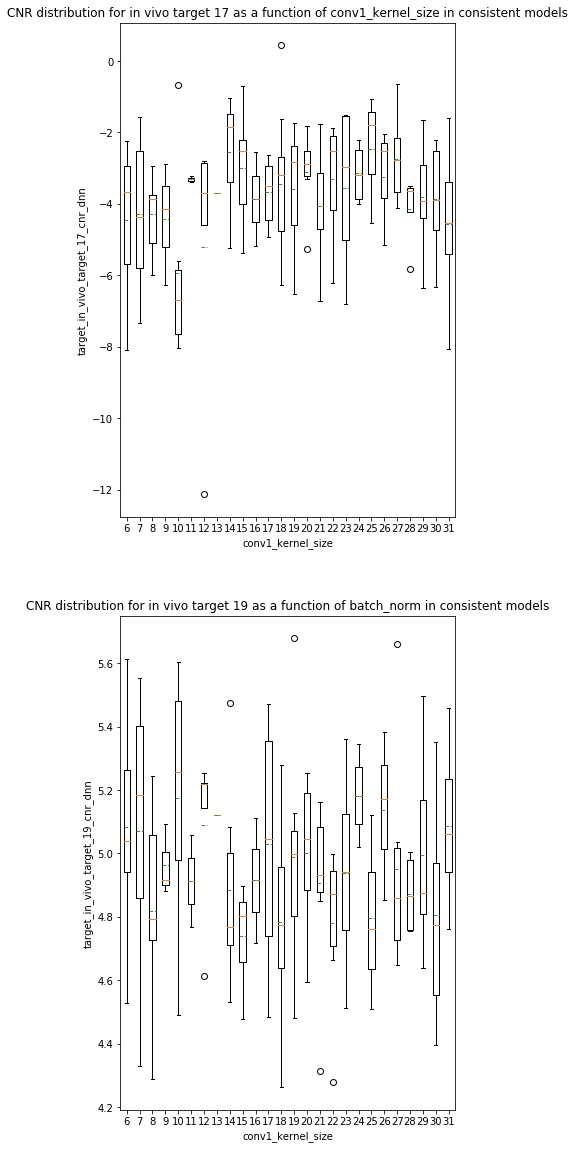

In [72]:
fig, axes = plt.subplots(2, figsize=(6, 20))

column = 'conv1_kernel_width'

axes[0].set_title('CNR distribution for in vivo target 17 as a function of {} in consistent models'.format(column))
boxplot_cnr_vs_discrete_attributes(column, 'target_in_vivo_target_17_cnr_dnn', consistent, ax=axes[0])


axes[1].set_title('CNR distribution for in vivo target 19 as a function of batch_norm in consistent models')
boxplot_cnr_vs_discrete_attributes(column, 'target_in_vivo_target_19_cnr_dnn', consistent, ax=axes[1])

plt.show()

# Distribution of conv1_num_kernels among consistent vs inconsistent models

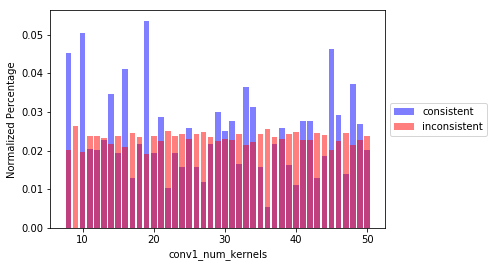

In [29]:
# Note: we didn't allow larger kernel sizes until later
consistent_vs_inconsistent_discrete('conv1_num_kernels', show_numbers=False)

# Distribution of conv1_stride among consistent vs inconsistent models

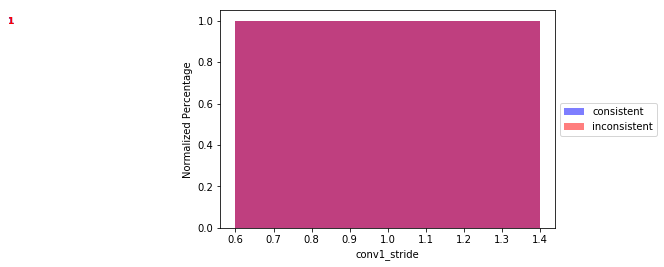

In [30]:
# Note: we didn't allow larger kernel sizes until later
consistent_vs_inconsistent_discrete('conv1_stride')

# Distribution of pool1_kernel_size among consistent vs inconsistent models

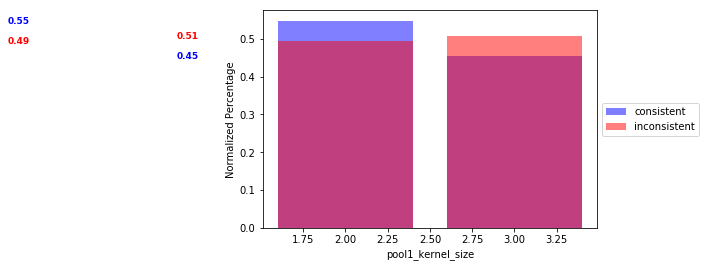

In [31]:
# Note: we didn't allow larger kernel sizes until later
# NOTE: this doesn't consider use_pool == 0
consistent_vs_inconsistent_discrete('pool1_kernel_size')


discrete_column_values = [2, 3]
len(cnr_dists_for_discrete_column_value) = 84
len(cnr_dists_for_discrete_column_value) = 72
discrete_column_values = [2, 3]
len(cnr_dists_for_discrete_column_value) = 84
len(cnr_dists_for_discrete_column_value) = 72


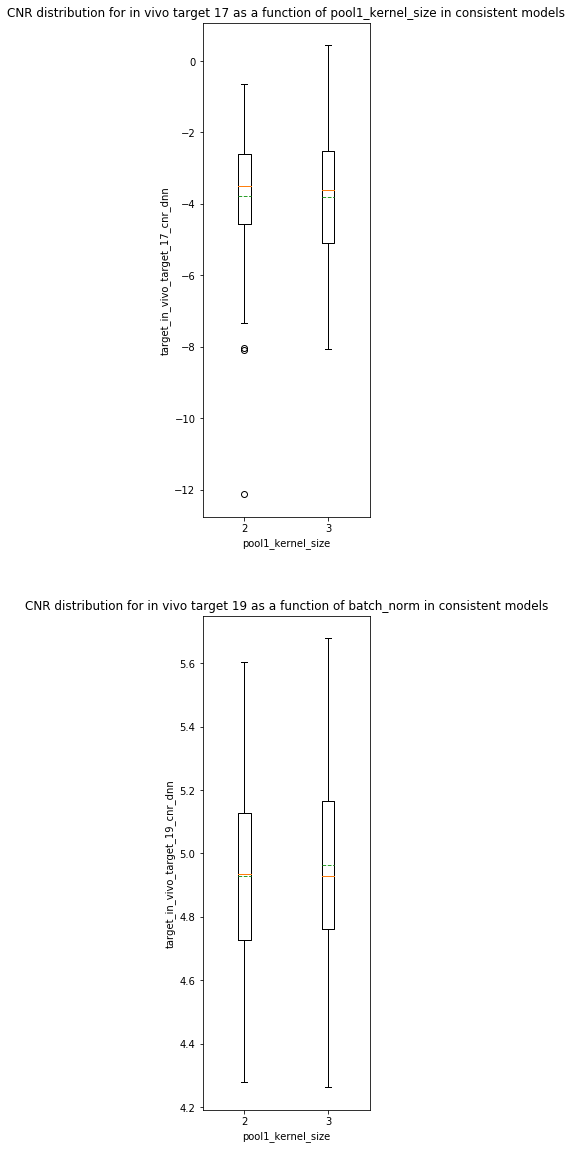

In [74]:
fig, axes = plt.subplots(2, figsize=(3, 20))

column = 'pool1_kernel_size'

axes[0].set_title('CNR distribution for in vivo target 17 as a function of {} in consistent models'.format(column))
boxplot_cnr_vs_discrete_attributes(column, 'target_in_vivo_target_17_cnr_dnn', consistent, ax=axes[0])


axes[1].set_title('CNR distribution for in vivo target 19 as a function of batch_norm in consistent models')
boxplot_cnr_vs_discrete_attributes(column, 'target_in_vivo_target_19_cnr_dnn', consistent, ax=axes[1])

plt.show()

# Distribution of pool1_stride among consistent vs inconsistent models

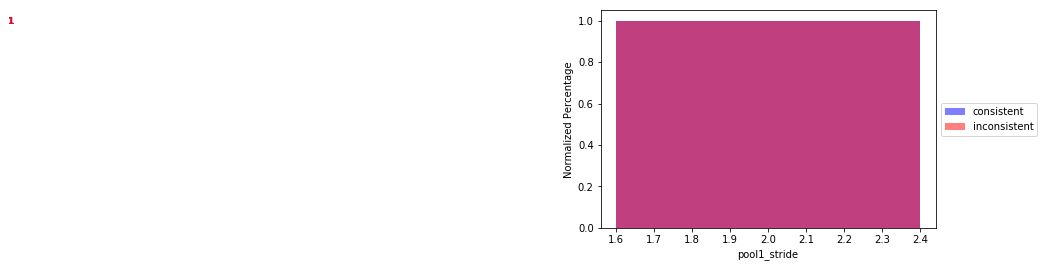

In [32]:
# Note: we didn't allow larger kernel sizes until later
consistent_vs_inconsistent_discrete('pool1_stride')

discrete_column_values = [2]
len(cnr_dists_for_discrete_column_value) = 156
discrete_column_values = [2]
len(cnr_dists_for_discrete_column_value) = 156


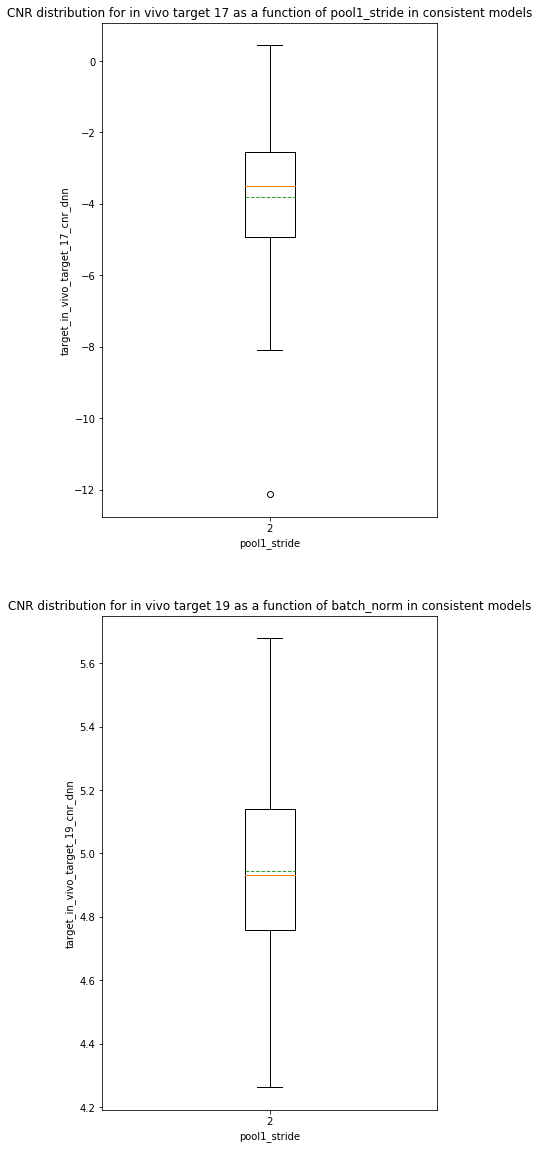

In [75]:
fig, axes = plt.subplots(2, figsize=(6, 20))

column = 'pool1_stride'

axes[0].set_title('CNR distribution for in vivo target 17 as a function of {} in consistent models'.format(column))
boxplot_cnr_vs_discrete_attributes(column, 'target_in_vivo_target_17_cnr_dnn', consistent, ax=axes[0])


axes[1].set_title('CNR distribution for in vivo target 19 as a function of batch_norm in consistent models')
boxplot_cnr_vs_discrete_attributes(column, 'target_in_vivo_target_19_cnr_dnn', consistent, ax=axes[1])

plt.show()

# Distribution of conv2_kernel_size among consistent vs inconsistent models

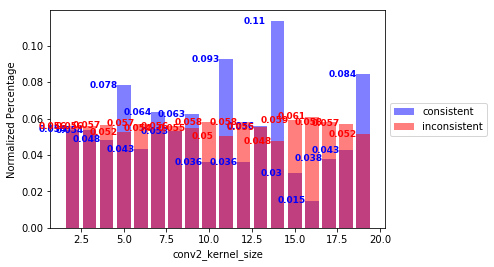

In [33]:
# Note: we didn't allow larger kernel sizes until later
consistent_vs_inconsistent_discrete('conv2_kernel_size')

# Distribution of conv2_num_kernels among consistent vs inconsistent models

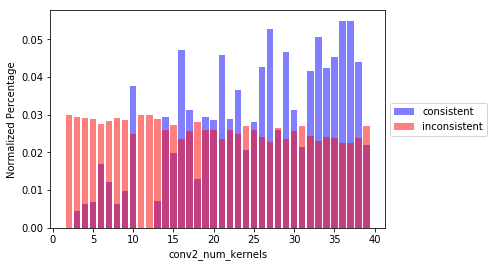

In [34]:
consistent_vs_inconsistent_discrete('conv2_num_kernels', show_numbers=False)

# Distribution of conv2_stride among consistent vs inconsistent models

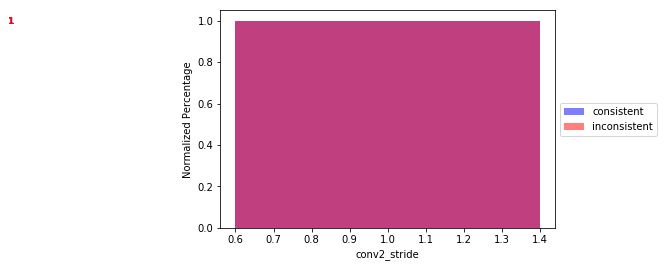

In [35]:
consistent_vs_inconsistent_discrete('conv2_stride')

# Distribution of conv2_dropout among consistent vs inconsistent models

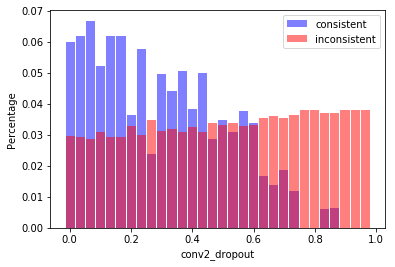

In [36]:
consistent_vs_inconsistent_continuous('conv2_dropout', bins=30)

# Distribution of pool2_kernel_size among consistent vs inconsistent models

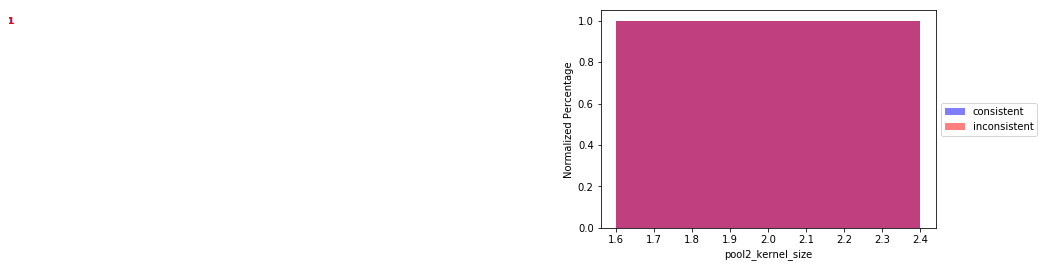

In [37]:
consistent_vs_inconsistent_discrete('pool2_kernel_size')

# Distribution of pool2_stride among consistent vs inconsistent models

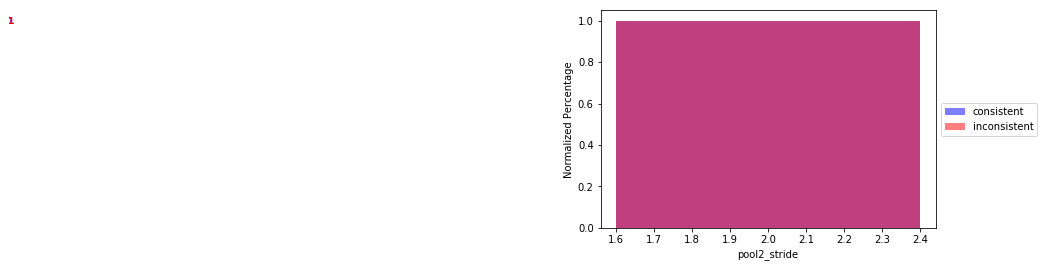

In [38]:
consistent_vs_inconsistent_discrete('pool2_stride')

# Distribution of fcs_hidden_size among consistent vs inconsistent models

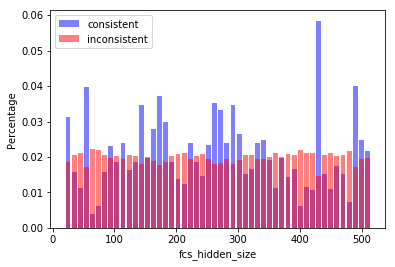

In [39]:
# consistent_vs_inconsistent_discrete('fcs_hidden_size')
consistent_vs_inconsistent_continuous('fcs_hidden_size', bins=50, width=8)


# Distribution of fcs_dropout among consistent vs inconsistent models

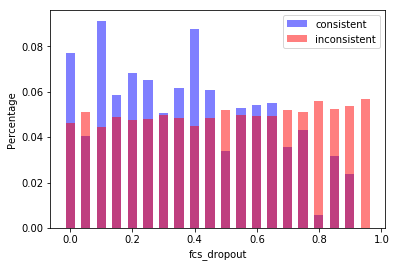

In [40]:
consistent_vs_inconsistent_continuous('fcs_dropout', bins=20)

# Distribution of fcs_num_hidden_layers among consistent vs inconsistent models

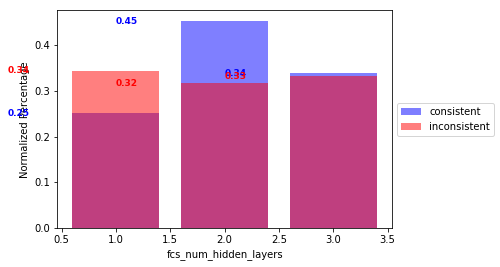

In [41]:
consistent_vs_inconsistent_discrete('fcs_num_hidden_layers')

discrete_column_values = [1, 2, 3]
len(cnr_dists_for_discrete_column_value) = 50
len(cnr_dists_for_discrete_column_value) = 59
len(cnr_dists_for_discrete_column_value) = 47
discrete_column_values = [1, 2, 3]
len(cnr_dists_for_discrete_column_value) = 50
len(cnr_dists_for_discrete_column_value) = 59
len(cnr_dists_for_discrete_column_value) = 47


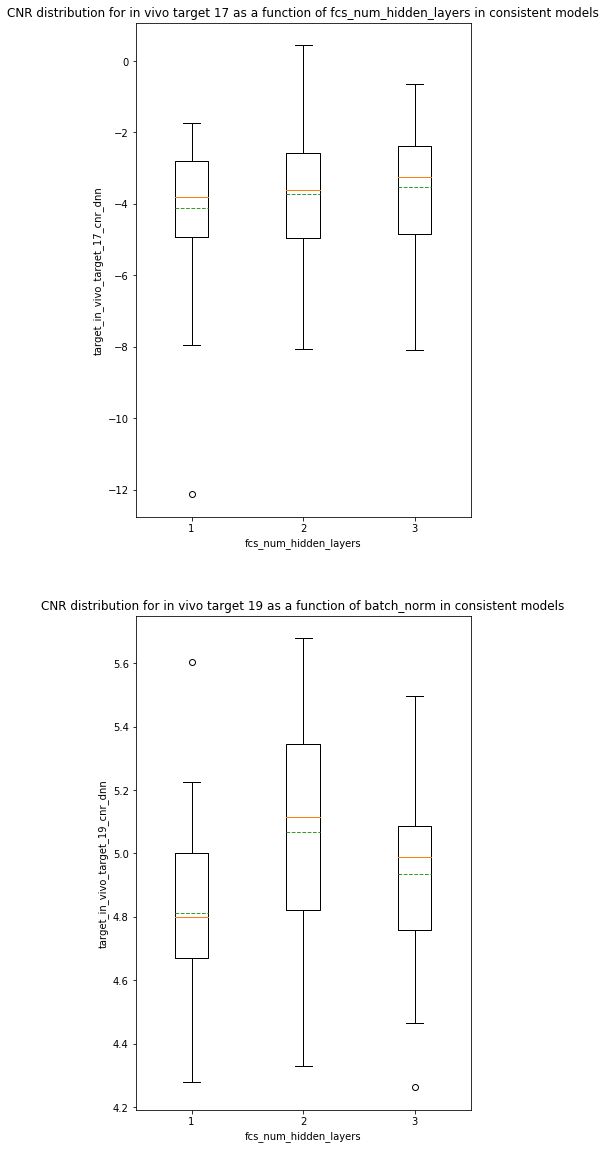

In [76]:
fig, axes = plt.subplots(2, figsize=(6, 20))

column = 'fcs_num_hidden_layers'

axes[0].set_title('CNR distribution for in vivo target 17 as a function of {} in consistent models'.format(column))
boxplot_cnr_vs_discrete_attributes(column, 'target_in_vivo_target_17_cnr_dnn', consistent, ax=axes[0])


axes[1].set_title('CNR distribution for in vivo target 19 as a function of batch_norm in consistent models')
boxplot_cnr_vs_discrete_attributes(column, 'target_in_vivo_target_19_cnr_dnn', consistent, ax=axes[1])

plt.show()

# Percentage of Adam among consistent vs inconsistent models

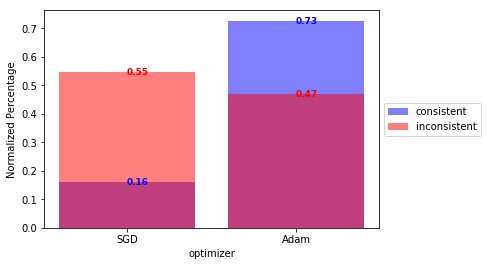

In [42]:
consistent_vs_inconsistent_discrete('optimizer')


discrete_column_values = ['Adam', 'SGD']
len(cnr_dists_for_discrete_column_value) = 136
len(cnr_dists_for_discrete_column_value) = 20
discrete_column_values = ['Adam', 'SGD']
len(cnr_dists_for_discrete_column_value) = 136
len(cnr_dists_for_discrete_column_value) = 20


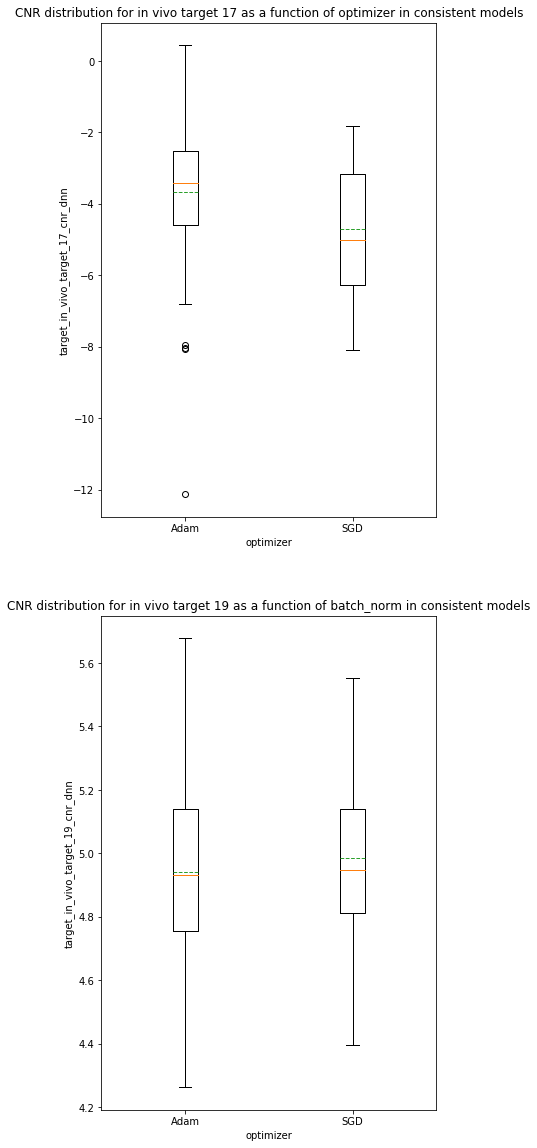

In [77]:
fig, axes = plt.subplots(2, figsize=(6, 20))

column = 'optimizer'

axes[0].set_title('CNR distribution for in vivo target 17 as a function of {} in consistent models'.format(column))
boxplot_cnr_vs_discrete_attributes(column, 'target_in_vivo_target_17_cnr_dnn', consistent, ax=axes[0])


axes[1].set_title('CNR distribution for in vivo target 19 as a function of batch_norm in consistent models')
boxplot_cnr_vs_discrete_attributes(column, 'target_in_vivo_target_19_cnr_dnn', consistent, ax=axes[1])

plt.show()

# Distribution of loss_val_k_4

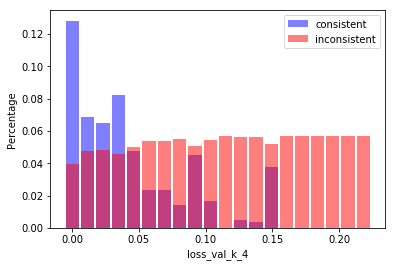

In [43]:
consistent_vs_inconsistent_continuous('loss_val_k_4', bins=20, width=0.01)


# Loss functions among consistent vs inconsistent models

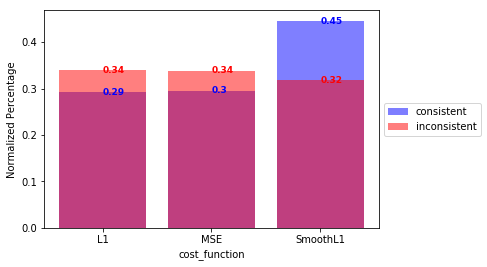

In [44]:
consistent_vs_inconsistent_discrete('cost_function')

discrete_column_values = ['L1', 'MSE', 'SmoothL1']
len(cnr_dists_for_discrete_column_value) = 37
len(cnr_dists_for_discrete_column_value) = 65
len(cnr_dists_for_discrete_column_value) = 54
discrete_column_values = ['L1', 'MSE', 'SmoothL1']
len(cnr_dists_for_discrete_column_value) = 37
len(cnr_dists_for_discrete_column_value) = 65
len(cnr_dists_for_discrete_column_value) = 54


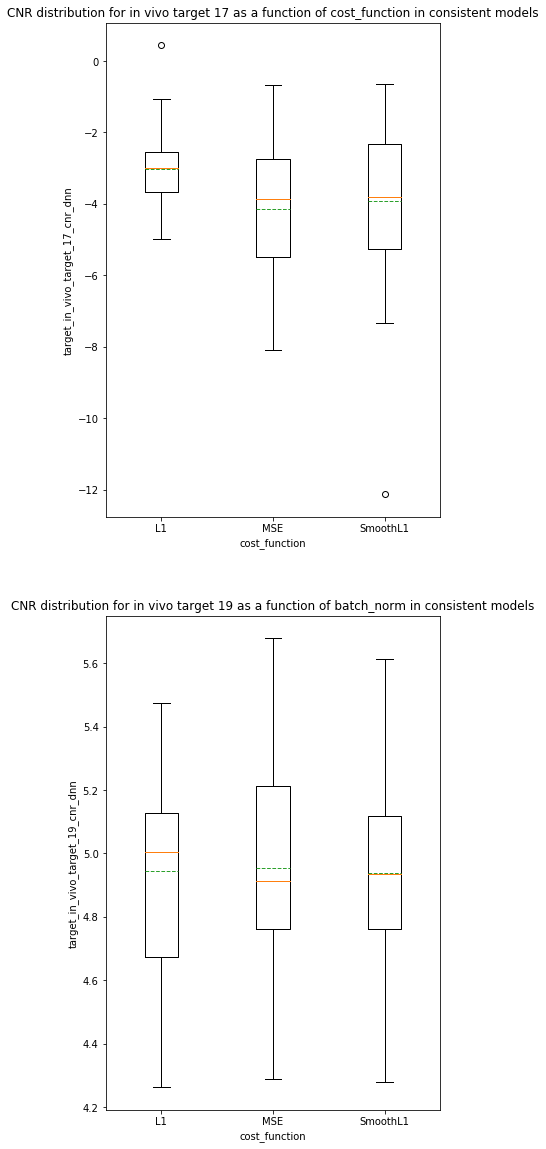

In [78]:
fig, axes = plt.subplots(2, figsize=(6, 20))

column = 'cost_function'

axes[0].set_title('CNR distribution for in vivo target 17 as a function of {} in consistent models'.format(column))
boxplot_cnr_vs_discrete_attributes(column, 'target_in_vivo_target_17_cnr_dnn', consistent, ax=axes[0])


axes[1].set_title('CNR distribution for in vivo target 19 as a function of batch_norm in consistent models')
boxplot_cnr_vs_discrete_attributes(column, 'target_in_vivo_target_19_cnr_dnn', consistent, ax=axes[1])

plt.show()